In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import string
import gensim
from gensim.models import Word2Vec
from gensim.models import FastText
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import glob
import os
from sklearn.model_selection import train_test_split

import tensorflow as tf
from dotenv import load_dotenv
from pathlib import Path

env_path = '/data/dssg-disinfo/.env'
load_dotenv(env_path, override=True)
# settings.py
PATH = os.getenv("PATH")

# nltk.download('punkt') ## Run this once before running the code

In [11]:
#read and concatanate negative and positive articles
#df = pd.read_csv('/data/dssg-disinfo/articles_v3.csv')

# df = df[df['label'] == 1]
# Remove the special characters
# If there are any characters \n or special characters present uncomment this
#df['article_text'] = [article.replace('\n', ' ') for article in df.article_text]
#df['article_text'] = [article.replace('[^a-zA-Z\d\s:]', ' ') for article in df.article_text]
#df['article_text'] = df['article_text'].str.lower()

#df_articles = df['article_text'].tolist()

### Using UW Data --->

df = pd.read_csv(os.path.join(PATH,'uw_data1.csv'))
df_articles = df['article'].tolist()

In [10]:
#tokenizing words in each article to create list of lists
tokenized_list = []

for item in df_articles:
    tokenized_word = word_tokenize(item)
    tokenized_list.append(tokenized_word)

NameError: name 'df_articles' is not defined

## FastText

In [6]:
model_fasttext=FastText(tokenized_list, min_count=10, size= 300, window=10)

In [7]:
print(model_fasttext)

FastText(vocab=63602, size=300, alpha=0.025)


In [9]:
# Save the model
filename = '/data/dssg-disinfo/word-embeddings/fasttext_300d_embeddings.wv'
model_fasttext.save(filename)

In [11]:
model_fasttext.most_similar('coronavirus')

/home/richa/.conda/envs/dssg/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('coronaviruss', 0.9769521951675415),
 ('coronavirus-19', 0.9733467102050781),
 ("'coronavirus", 0.9624966979026794),
 ('non-coronavirus', 0.9508402943611145),
 ('coronavirus-like', 0.9353148341178894),
 ('corona-virus', 0.9322391748428345),
 ('pre-coronavirus', 0.9270610809326172),
 ('coronavirus-free', 0.9242501854896545),
 ('coronvirus', 0.9129698872566223),
 ('anti-coronavirus', 0.910959780216217)]

## Word2Vec

In [20]:
model = Word2Vec(tokenized_list, min_count=10,size= 200,workers=3, window =3, sg = 1)

In [21]:
print(model)

Word2Vec(vocab=53903, size=200, alpha=0.025)


In [23]:
words = list(model.wv.vocab)

model.most_similar('virus')

/home/hope/.conda/envs/hope/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('disease', 0.7281298041343689),
 ('infection', 0.6743493676185608),
 ('covid-19', 0.6713500618934631),
 ('coronavirus', 0.663510262966156),
 ('coronvirus', 0.6041020154953003),
 ('illness', 0.5998390316963196),
 ('re-infection', 0.5990270376205444),
 ('reinfection', 0.5954970121383667),
 ('presymptomatic', 0.5866572856903076),
 ('coroanvirus', 0.5845031142234802)]

In [24]:
model2 = model.similarity('virus', 'coronavirus')

word = "virus"

/home/hope/.conda/envs/hope/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


/home/hope/.conda/envs/hope/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """
/home/hope/.conda/envs/hope/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/hope/.conda/envs/hope/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/home/hope/.conda/envs/hope/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/home/hope/.conda/envs/hope/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to 

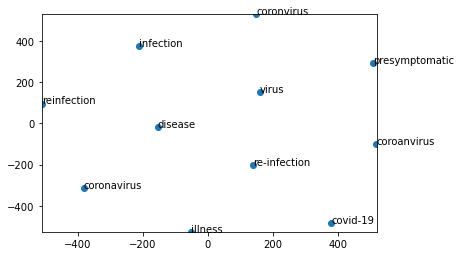

In [25]:
def display_closestwords_tsnescatterplot(model, word, size):
    arr = np.empty((0,200), dtype='f') 
    word_labels = [word]

    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

        tsne = TSNE(n_components=2, random_state=0)
        np.set_printoptions(suppress=True)
        Y = tsne.fit_transform(arr)
    
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
display_closestwords_tsnescatterplot(model, word, 100)